In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import operator
import networkx as nx
import math
import matplotlib.patches as mpatches

from util.api import get_pkgs_usage_count, foo, get_lts_list

%matplotlib inline
plt.style.use('classic')

In [2]:
lts_list = get_lts_list()
df_list = []
df_by_category_list = []

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}.df')
    df_list.append(df)
    

# Research Questions (RQs)

- **RQ 1.** What packages are the most used? Which of them are outside from the Stackage selection?
- **RQ 2.** How many dependencies of packages are outside from the Stackage selection (in)directly?
- **RQ 3.** How frequently are the packages updated? 

Regarding monads, we analyze the evolution of dependencies of monad modules available in the mtl package:

- **RQ 4.** How has the use of monads evolved?
- **RQ 5.** Are there packages that stopped using monads?


## RQ 1. What packages are the most used? Which of them are outside from the Stackage selection?

Consideramos el ultimo snapshot publicado en Stackage, especificamente el LTS 16.11. Utilizamos el campo **Dependencies** del DataFrame para obtener el listado de las dependencias de cada paquete y construimos un diccionario de todos los paquetes y sus dependencias. Contamos la cantidad de veces que fue requerido cada uno de ellos para posteriormente ordenarlos ascendentemente y filtrar el top 25 de los mas utilizados. Luego, restamos el conjunto de todos los paquetes seleccionados del LTS 16.11 a la lista de los top 25 mas utilizados para obtener los paquetes que no formaron parte de la seleccion.

Descubrimientos:

- Pregunta 1    
    - El top 5 de los paquetes mas usados se mantuvo a lo largo de las 14 versiones LTS analizadas, estos son: base, bytestring, containers, text, and transformers
    - MTL, tiene un rol importante en lenguaje y mantiene el top 6 a lo largo de las versiones consideras
- Pregunta 2
    - Descubrimos que dentro de los 22 paquetes mas usados en las versiones [15-3 y 16-11] se ubica quickchek un libreria utilzia para hacer tests que no se encuentra en la seleccion realizada por stackage
    - Analizando en profundiad este caso, descrubirmos que existen una gran cantidad de paquetes que son utilizados pero no son parte de la seleccion -> (Esto da paso a la pregunta 2) 

In [3]:
top_25_pkgs = []
top_25_count = []
top_25_list = dict()

for idx, lts in enumerate(lts_list):
    top_25 = dict()
    packet_usage_count = get_pkgs_usage_count(df_list[idx])
    ordered_pkgs = sorted(packet_usage_count, key=packet_usage_count.get, reverse=True)[:25]

    for pkg in ordered_pkgs:
        top_25_pkgs.append(pkg)
        top_25_count.append(packet_usage_count[pkg])
        top_25[pkg] = packet_usage_count[pkg]
    
    top_25_list[lts] = top_25 

In [11]:
dic_lts = {'0-7':0,'12-26':8,'18-18':18}
dfs = [{},{},{}]
lista = []
for idx,lts in enumerate (dic_lts):
    indice = idx
    pkg = []
    deps = []
    df_lts1 = pd.DataFrame()
    top_pkg = list(top_25_list[lts].keys())[1:11]
    for idx, row in df_list[dic_lts[lts]].iterrows():
        for dependency in list(row['deps']):
            if dependency in top_pkg:
                pkg.append(row['package'])
                deps.append(dependency)
    df_lts1['package'] = pkg
    df_lts1['deps'] = deps

    list_cat = {}
    for pkg in top_pkg:  
        if pkg == 'aeson':
            list_cat[pkg] = (list(df_list[dic_lts[lts]][df_list[dic_lts[lts]]['package']==pkg]['categories'])[0][1])
        else:
            list_cat[pkg] = (list(df_list[dic_lts[lts]][df_list[dic_lts[lts]]['package']==pkg]['categories'])[0][0])
    def get_coordinates_in_circle(n):
        thetas = [2*np.pi*(float(i)/n) for i in range(n)]
        returnlist = [(8*np.cos(theta),8*np.sin(theta)) for theta in thetas]
        return returnlist

    G = nx.from_pandas_edgelist(df_lts1, 'deps', 'package')

    degrees = dict(nx.degree(G))
    nx.set_node_attributes(G, name='degree', values=degrees)

    number_to_adjust_by = 3
    adjusted_node_size = dict([(node, degree*number_to_adjust_by) for node, degree in nx.degree(G)])
    nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

    nx.set_node_attributes(G, name='categories', values=1)
    for node in G.nodes():
        if node in top_pkg:
            G.nodes[node]['categories'] = list_cat[node]
        else:
            G.nodes[node]['categories'] = 'others'

    labeldict = {}
    posdict = {}
    for node in G.nodes():  
        if node in top_pkg:
            labeldict[node] = node

    circular_positions = get_coordinates_in_circle(len(top_pkg))
    if indice == 0:
        lista = top_pkg
        fixed_nodes = top_pkg
    else:
        aux = []
        for i in range(len(lista)):
            if lista[i] == top_pkg[i]:
                aux.append(lista[i])
            else:
                count = 0
                for j in range(len(top_pkg)):
                    if lista[i] == top_pkg[j] and top_pkg[j]:
                        count+=1
                        aux.append(lista[i])
                if count == 0:
                    for x in range(len(top_pkg)):
                        if top_pkg[x] not in aux and top_pkg[x] not in lista and count != 1:
                            aux.append(top_pkg[x])     
                            count+=1
        fixed_nodes = aux

    pos = {}
    for i,p in enumerate(fixed_nodes):
        pos[p] = circular_positions[i]

    pos = nx.spring_layout(G,pos=pos, fixed=fixed_nodes,scale=2,k=0.3)
    
    node_color = []
    for node in G.nodes():
        if node == 'time':
            print(G.nodes[node]['categories'])
        if G.nodes[node]['categories'] == 'data':
            node_color.append('dodgerblue')
        elif G.nodes[node]['categories'] == 'data structures':
            node_color.append('darkturquoise')
        elif G.nodes[node]['categories'] == 'control':
            node_color.append('yellow')
        elif G.nodes[node]['categories'] == 'web':
            node_color.append('lightseagreen')
        elif G.nodes[node]['categories'] == 'system':
            node_color.append('skyblue')
        else:
            node_color.append('green')
            
    blue_patch = mpatches.Patch(color='dodgerblue', label='data')        
    cyan_patch = mpatches.Patch(color='darkturquoise', label='data structures')        
    teal_patch = mpatches.Patch(color='yellow', label='control')          
    tea1l_patch = mpatches.Patch(color='lightseagreen', label='web')      
    yellow_patch = mpatches.Patch(color='skyblue', label='system')     
    green_patch = mpatches.Patch(color='green', label='others')
    dfs[indice]['G']= G
    dfs[indice]['pos']= pos
    dfs[indice]['labeldict']= labeldict
    dfs[indice]['node_color']= node_color
    dfs[indice]['adjusted_node_size']= adjusted_node_size

system
time
time


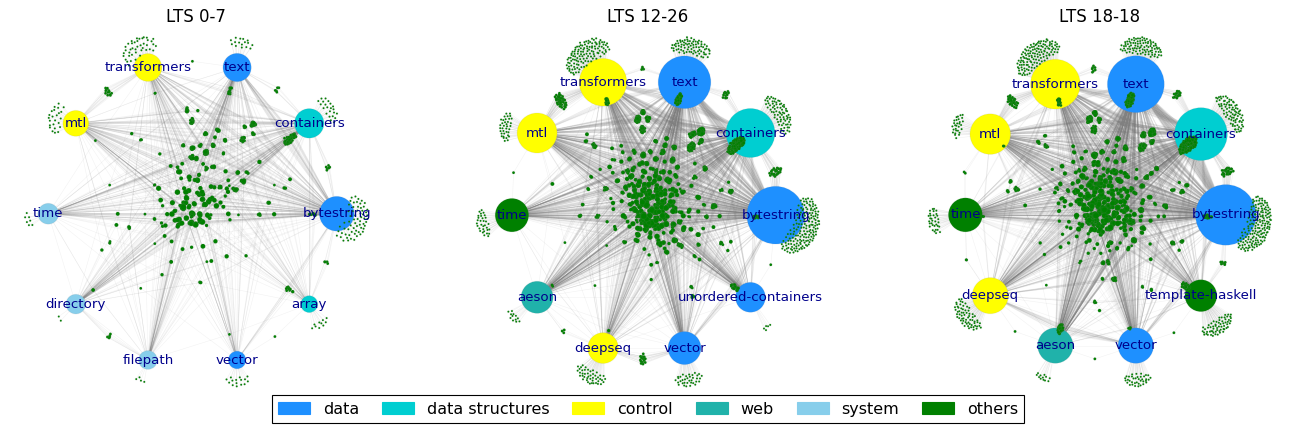

In [12]:
fig = plt.figure(figsize=(20,6))
color = (0.5, 0.5, 0.5, 0.1)

for i in range(len(dfs)): 
    plt.subplot(1,3,i+1)
    nx.draw(dfs[i]['G'],pos=dfs[i]['pos'],label=True, labels=dfs[i]['labeldict'],node_size=list(dfs[i]['adjusted_node_size'].values()),
                   edgecolors=color,width=0.5,edge_color=color,font_size=12,node_color = (dfs[i]['node_color']),font_color='darkblue')
    plt.title('LTS '+list(dic_lts.keys())[i], fontsize=15, y=0.98)  
    plt.subplots_adjust(left=0,right=0.8)
    plt.margins(x=0,y=0)
    if i == 1:       
        plt.legend(handles=[blue_patch,cyan_patch,teal_patch,tea1l_patch,yellow_patch,green_patch],bbox_to_anchor=(-0.5, -0.05, 2., .102), loc='lower left',
               ncol=6, mode="expand", borderaxespad=0.)
plt.savefig("../../graphs/rq1.pdf", format='pdf', bbox_inches='tight')


plt.show()

In [15]:
df_list[0][df_list[0]['package']=='aeson']['categories']

aeson-0.8.0.2    [text, web, json]
Name: categories, dtype: object

In [6]:
for idx,df in enumerate(df_list):
    print('-----------------------')
    print('Processing LTS-',lts_list[idx])
    foo(df)

-----------------------
Processing LTS- 0-7
-----------------------
Processing LTS- 2-22
-----------------------
Processing LTS- 3-22
-----------------------
Processing LTS- 6-35
-----------------------
Processing LTS- 7-24
-----------------------
Processing LTS- 9-21
-----------------------
Processing LTS- 11-22
-----------------------
Processing LTS- 12-14
-----------------------
Processing LTS- 12-26
-----------------------
Processing LTS- 13-11
-----------------------
Processing LTS- 13-19
-----------------------
Processing LTS- 14-27
-----------------------
Processing LTS- 15-3
-----------------------
Processing LTS- 16-11
-----------------------
Processing LTS- 16-31
-----------------------
Processing LTS- 17-2
-----------------------
Processing LTS- 18-6
-----------------------
Processing LTS- 18-8
-----------------------
Processing LTS- 18-18


In [7]:
out_range = []
out_range_percentage =[]
total = []
list_out_range = []
list_in_range = []
list_any = []
for idx,df in enumerate(df_list):
    dict_out_range = []
    dict_in_range = []
    dict_any = []
    count_out_range = 0
    count_total = 0
    for idx,row in df.iterrows():
        pkg = row['package']
        deps = row['dependencies_status']
        for dep in deps:
            if deps[dep] == 'OUT_RANGE':
                count_out_range+=1
                dict_out_range.append((pkg,dep))
            elif deps[dep] == 'IN_RANGE':
                dict_in_range.append(dep)
            else:
                dict_any.append(dep)
            count_total+=1
    list_out_range.append(dict_out_range)
    list_in_range.append(dict_in_range)
    list_any.append(dict_any)
    out_range.append(count_out_range)
    out_range_percentage.append(count_out_range/count_total)
    total.append(count_total)

In [8]:
list_conflict = []
percentage = []
unique_out_range = []
for idx,array in enumerate(list_out_range):
    count = 0
    pkg_out_range = []
    print('lts-',lts_list[idx])
    for pkg,dep in list_out_range[idx]:
        if dep in list_in_range[idx]:
            count+=1
        else:
            pkg_out_range.append((pkg,dep))
    pkg_out_range = pkg_out_range
    unique_out_range.append(pkg_out_range)
    list_conflict.append(count)
    percentage.append(count/total[idx])
    print('Total dependencies with OUT_RANGE: ',len(list_out_range[idx]))
    print('Total dependencies with IN_RANGE: ',len(list_in_range[idx]))
    print('Total dependencies with ANY: ',len(list_any[idx]))
    print('Total dependencies: ',total[idx])

lts- 0-7
Total dependencies with OUT_RANGE:  10
Total dependencies with IN_RANGE:  3918
Total dependencies with ANY:  1701
Total dependencies:  5629
lts- 2-22
Total dependencies with OUT_RANGE:  12
Total dependencies with IN_RANGE:  5267
Total dependencies with ANY:  2274
Total dependencies:  7553
lts- 3-22
Total dependencies with OUT_RANGE:  33
Total dependencies with IN_RANGE:  6942
Total dependencies with ANY:  2969
Total dependencies:  9944
lts- 6-35
Total dependencies with OUT_RANGE:  72
Total dependencies with IN_RANGE:  10292
Total dependencies with ANY:  4881
Total dependencies:  15245
lts- 7-24
Total dependencies with OUT_RANGE:  106
Total dependencies with IN_RANGE:  11177
Total dependencies with ANY:  5001
Total dependencies:  16284
lts- 9-21
Total dependencies with OUT_RANGE:  119
Total dependencies with IN_RANGE:  12206
Total dependencies with ANY:  5528
Total dependencies:  17853
lts- 11-22
Total dependencies with OUT_RANGE:  129
Total dependencies with IN_RANGE:  11584
T

[10, 12, 33, 72, 106, 119, 129, 196, 182, 296, 279, 203, 289, 267, 228, 284, 262, 260, 221]


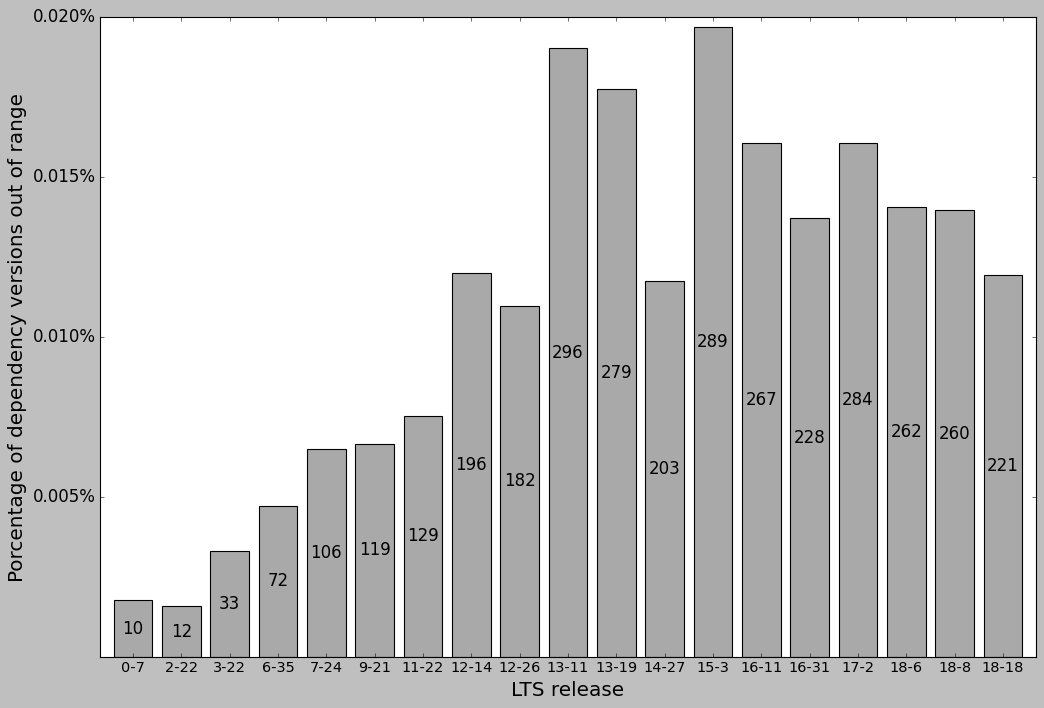

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)
print(out_range)
bar = ax.bar(x=lts_list, height=out_range_percentage, width=0.8, color='darkgrey', align='center', label='Dependdencies out of range')
ax.bar_label(bar, labels=list(out_range), label_type='center', color='black', fontsize=15)

ax.set_xticks(lts_list)
ax.set_xticklabels(lts_list,fontsize=13)
ax.set_yticks([0.005, 0.010, 0.015,0.020])
ax.set_yticklabels(['0.005%', '0.010%', '0.015%','0.020%'],fontsize=15)
ax.set_xlabel('LTS release',fontsize=18)
ax.set_ylabel('Porcentage of dependency versions out of range',fontsize=18)

plt.savefig("../../graphs/rq1_2.pdf", format='pdf', bbox_inches='tight')
plt.show()

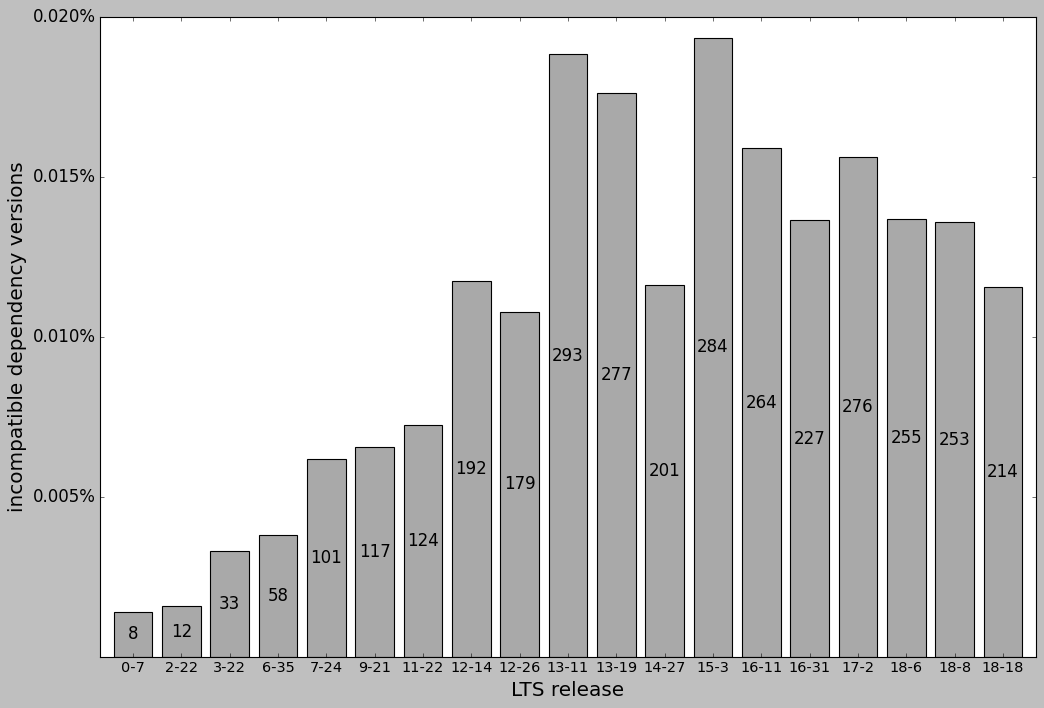

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

bar = ax.bar(x=lts_list, height=percentage, width=0.8, color='darkgrey', align='center', label='Dependdencies inconsistent')
ax.bar_label(bar, labels=list(list_conflict), label_type='center', color='black', fontsize=15)

ax.set_xticks(lts_list)
ax.set_xticklabels(lts_list,fontsize=13)
ax.set_yticks([0.005, 0.010, 0.015,0.020])
ax.set_yticklabels(['0.005%', '0.010%', '0.015%','0.020%'],fontsize=15)
ax.set_xlabel('LTS release',fontsize=18)
ax.set_ylabel('incompatible dependency versions',fontsize=18)

plt.savefig("../../graphs/rq1_3.pdf", format='pdf', bbox_inches='tight')
plt.show()